<a href="https://colab.research.google.com/github/ric4234/AI-Fridays/blob/main/Analisi%20di%20Serie%20Temporali/02_Prophet.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prophet Model

Prophet is a model developed by Meta (Facebook), used by Meta itself to make reliable forecasts for planning and goal-setting. It has been released by Meta as open source, allowing for free usage and customization.

Prophet allows for the estimation of trends and seasonalities on a monthly, weekly, and daily basis.

Prophet is an additive regression model based on three main components:

*   **Trend**: A segmented linear or logistic growth trend. Prophet automatically detects changes in the trend by selecting changepoints from the data.
*   **Annual and weekly seasonal components**: Modeled using Fourier series with periods P=365.25 and P=7.
*   **List of holidays/significant days**: User can specify holidays (Christmas, New Year, Easter, etc.) or relevant days (e.g., Black Friday)

Prophet forecast is represented in the following way:

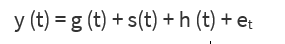

Where g(t) is the trend component, s(t) the seasonality, h(t) the holidays effect and e(t) epresents random variations assumed to be normally distributed (Gaussian). Each function (g, s, h) has its own weight and is characterized by a set of parameters that need to be optimized to improve the model's fit to the data.

The weight of each component needs to be tuned and its related to an hyperparameter:


*   **Changepoint Prior Scale**: This is related to the trend.  
*   Voce elenco



Finally, Prophet can be used for univariate models only. This means that  Prophet only makes forecasts with only one dependent variable. If you’d want to adapt to multivariate forecasts, you’d need to train a Prophet for each dependent variable separately.





#### 1 - Importing Data

Data: Daily number of shipments made by a courier service

Period of Record: June 2021 - February 2024

Number of observations: 1004
Number of variables: 2
Variable name definitions:

1.   date - sample date in YYYY-MM-DD format
2.   numero_spedizioni - number of shipments

Source: https://github.com/ric4234/AI-Fridays/blob/main/Dataset/dataset_spedizioni.csv

Raw Data Source: https://github.com/ric4234/AI-Fridays/raw/main/Dataset/dataset_spedizioni.csv

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# URL of the dataset on GitHub
url = "https://github.com/ric4234/AI-Fridays/raw/main/Dataset/dataset_spedizioni.csv"
# Load the dataset into a pandas DataFrame
df = pd.read_csv(url)
# Convert the 'data' column to datetime format
df['data'] = pd.to_datetime(df['data'])

# Display the informations of the dataframe
print(df.info())
# Display the first few rows of the DataFrame to verify it's loaded correctly
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data               1004 non-null   datetime64[ns]
 1   numero_spedizioni  1004 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.8 KB
None
        data  numero_spedizioni
0 2021-06-01             358890
1 2021-06-02               1192
2 2021-06-03             424296
3 2021-06-04             346785
4 2021-06-05                 10


#### 2 - Plotting Data

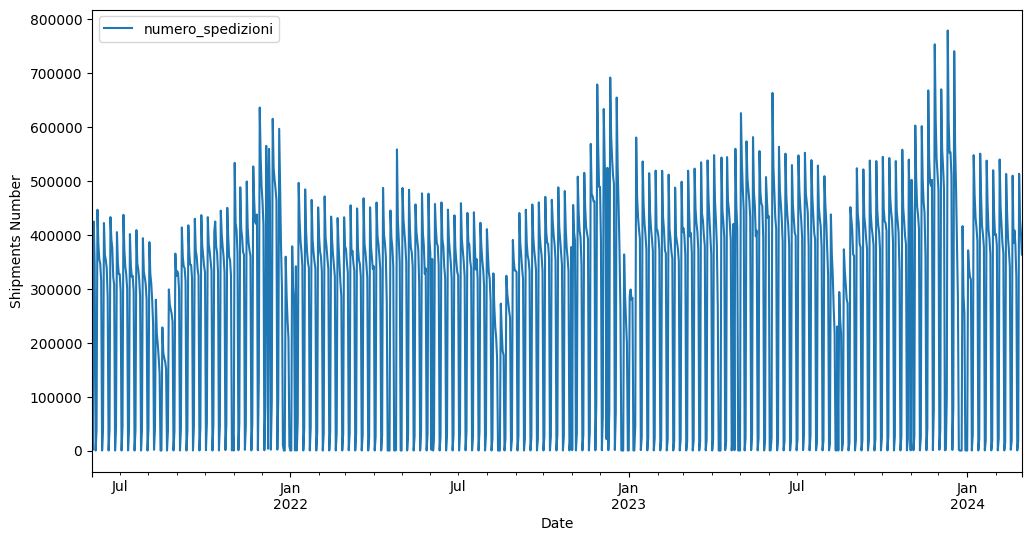

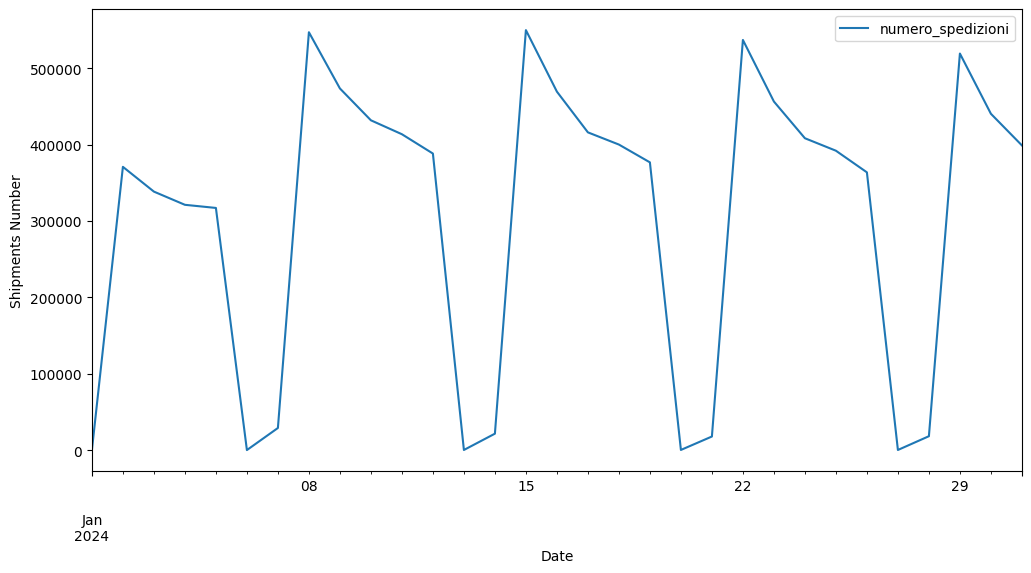

In [70]:
# Display all data
ax = df.plot(x='data', y='numero_spedizioni',figsize=(12,6))
ax.set_ylabel('Shipments Number')
ax.set_xlabel('Date')


# Display a data subset to explore weekly patterns
january_2024_data = df[(df['data'].dt.month == 1) & (df['data'].dt.year == 2024)]

ax_3 = january_2024_data.plot(x='data', y='numero_spedizioni',figsize=(12,6))
ax_3.set_ylabel('Shipments Number')
ax_3.set_xlabel('Date')

  # Adjust the width as needed
plt.show()

This time series shows peaks in the final months of the year (November, December) and minimums in the months of January (after the holidays) and August.

Focusing on the weekly patterns, we can see that we have a peak of shipments on Mondays, while the number of shipments is very low on weekends and holidays.

For the forecast of a time series like this one, weekly, yearly and holidays patterns needs to be taken in consideration.


#### 3 - Data Preparation

When building a Prophet model, it is mandatory to have a dataset with the
columns ‘ds’ and ‘y’.
This is how the model recognizes the date column (‘ds’) and the dependent variable (‘y’)

In [77]:
df = df.rename(columns={'data': 'ds'})
df = df.rename(columns={'numero_spedizioni': 'y'})

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1004 non-null   datetime64[ns]
 1   y       1004 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.8 KB
None


#### 4 - Hyperparameters Tuning

In Prophet, a possibile approach for Hyperparameters Tuning is the Cross Validation.

Cross Validation procedure can be done automatically for a range of historical cutoffs using the *cross_validation* function.
We need to specify the forecast horizon (*horizon*), and then optionally the size of the initial training period (*initial*) and the spacing between cutoff dates (*period*). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

The output of *cross_validation* is a dataframe with the true values y and the out-of-sample forecast values yhat, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between cutoff and cutoff + horizon. This dataframe can then be used to compute error measures of yhat vs. y.